# Earthquake seismology with DAS

See Figure 5 from Ajo-Franklin et al 2019:
https://www.nature.com/articles/s41598-018-36675-8

<!-- ![image.png](attachment:image.png) -->

In [1]:
import h5py
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import numpy as np
import datetime
import pandas as pd

import matplotlib.dates as mdates

from dasquakes import sintela_to_datetime, open_sintela_file, get_file_number

import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

In [7]:
event_df = pd.read_csv('pnsn_event_export_20220526.csv')
format_data = "%Y/%m/%d %H:%M:%S"
catalog_index = 2
t0 = datetime.datetime.strptime(event_df.iloc[catalog_index]['Time UTC'],format_data)
event_df

,Evid,Magnitude,Magnitude Type,Epoch(UTC),Time UTC,Time Local,Distance From,Lat,Lon,Depth Km,Depth Mi
0,61833727,3.3,l,1.653162e+09,2022/05/21 19:39:59,2022/05/21 12:39:59 PDT,"227.1 km from Colville, WA",50.3400,-116.4012,34.0,21.1
1,61832097,3.4,l,1.652775e+09,2022/05/17 08:07:34,2022/05/17 01:07:34 PDT,"25.5 km from Granite Falls, WA",48.2997,-121.8520,3.5,2.2
2,61835766,3.5,l,1.651404e+09,2022/05/01 11:15:56,2022/05/01 04:15:56 PDT,"2.3 km from Mount Vernon, WA",48.4193,-122.3072,14.5,9.0
3,61820227,3.5,l,1.649334e+09,2022/04/07 12:12:24,2022/04/07 05:12:24 PDT,"205.4 km from Port Hardy, BC",48.9662,-128.4003,5.4,3.3


In [8]:
data,dates,attrs = open_sintela_file('seadasn',t0,'/data/data0/seadasn/',number_of_files=2)
x_max=data.shape[1] * attrs['SpatialSamplingInterval']

In [9]:
low_cut = 1
hi_cut = 10

b,a = butter(2,(low_cut,hi_cut),'bp',fs=attrs['MaximumFrequency']*2)
data_filt = filtfilt(b,a,data,axis=0)

In [10]:
client = Client("IRIS")

t1 = UTCDateTime( t0.strftime("%Y-%m-%dT%H:%M:%S") )
dt = datetime.timedelta(minutes=1)
t2 = UTCDateTime( (t0+dt).strftime("%Y-%m-%dT%H:%M:%S") )

st = client.get_waveforms("UW", "NOWS", "--", "HNN", t1, t2, attach_response=True)
st.decimate(5, strict_length=False, no_filter=False) #everything should be at 40Hz now
st2 = client.get_waveforms("IU", "COR", "00", "BH1", t1, t2, attach_response=True)

pre_filt = (low_cut/2, low_cut, hi_cut, hi_cut*2)
st.remove_response(output='VEL', pre_filt=pre_filt)
st2.remove_response(output='VEL', pre_filt=pre_filt)

1 Trace(s) in Stream:
IU.COR.00.BH1 | 2022-05-01T11:15:56.019538Z - 2022-05-01T11:16:55.994538Z | 40.0 Hz, 2400 samples

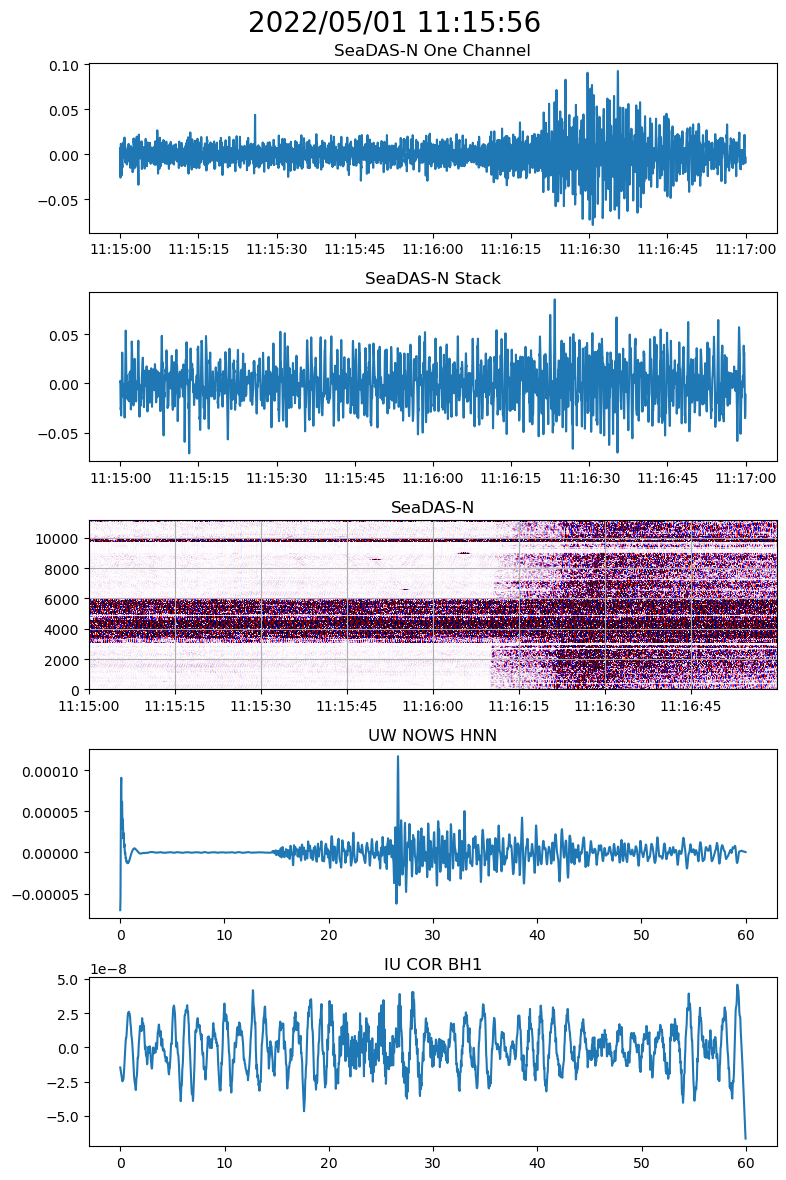

In [11]:
fig,ax=plt.subplots(figsize=(8,12))


ax = plt.subplot(5,1,1)
fig.patch.set_facecolor('w')

plt.plot(dates,data_filt[:,100])
ax.set_title('SeaDAS-N One Channel')

ax = plt.subplot(5,1,2)
fig.patch.set_facecolor('w')
exx = np.mean(data_filt,axis=1)

plt.plot(dates,exx)
ax.set_title('SeaDAS-N Stack')

ax=plt.subplot(5,1,3)
ax.set_title('SeaDAS-N')
# plt.imshow(data_filt.T,vmin=-0.1,vmax=0.1,cmap='seismic',aspect='auto')
x_lims = mdates.date2num(dates)
plt.imshow(data_filt.T,vmin=-.1,vmax=.1,cmap='seismic',aspect='auto', extent=[x_lims[0],x_lims[-1],0,x_max])
ax.xaxis_date()
date_format = mdates.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(date_format)
plt.grid()

ax = plt.subplot(5,1,4)
for tr in st:
    plt.plot(tr.times(),tr.data)
fig.patch.set_facecolor('w')
ax.set_title('UW NOWS HNN')

ax = plt.subplot(5,1,5)
for tr in st2:
    plt.plot(tr.times(),tr.data)
fig.patch.set_facecolor('w')
ax.set_title('IU COR BH1')

fig.suptitle(event_df.iloc[catalog_index]['Time UTC'],fontsize=20)
plt.tight_layout()
plt.show()